# Working with Numerical Data

In this tutorial, you will learn:

- What **feature vectors** are and why models need them
- How to **scale** numerical features (Min-Max, Z-score, Mean Normalization, Log)
- How to create **polynomial features** for non-linear relationships
- When and how to use **binning** (bucketing)
- How to **clean** (scrub) your data

We'll use the **Tips** dataset to demonstrate each concept.

> **Key insight**: Models work with processed **feature vectors**, not raw data. Good feature engineering can dramatically improve model performance.

---
## What is Numerical Data?

**Numerical data** consists of values that are:
- **Additive** — you can add/subtract them meaningfully
- **Countable** — they represent quantities
- **Ordered** — they have a natural ordering

**Examples**: Temperature, price, age, income

**Not numerical** (even if they look like numbers):
- Postal codes (90210) — adding them makes no sense
- Phone numbers — purely categorical

---
## Step 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)
sns.set_style('whitegrid')

---
## Step 2: Load the Tips Dataset

In [2]:
# Load Tips dataset
tips = sns.load_dataset('tips')
print(f"Dataset shape: {tips.shape}")
tips.head()

Dataset shape: (244, 7)


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [3]:
# Focus on numerical columns
numerical_cols = ['total_bill', 'tip', 'size']
print("Numerical features:")
print(tips[numerical_cols].describe())

Numerical features:
       total_bill         tip        size
count  244.000000  244.000000  244.000000
mean    19.785943    2.998279    2.569672
std      8.902412    1.383638    0.951100
min      3.070000    1.000000    1.000000
25%     13.347500    2.000000    2.000000
50%     17.795000    2.900000    2.000000
75%     24.127500    3.562500    3.000000
max     50.810000   10.000000    6.000000


---
## Feature Vectors

A **feature vector** is an array of floating-point values representing one example.

**Why not just use raw data?**

Models often perform *better* with transformed values. Feature engineering helps models:
- Converge faster during training
- Learn appropriate feature weights
- Avoid numerical issues (NaN, overflow)

In [4]:
# Each row is a feature vector
print("Example feature vector (first row):")
print(tips[numerical_cols].iloc[0].values)

Example feature vector (first row):
[16.99  1.01  2.  ]


---
## Exploring Feature Distributions

Before transforming data, we need to understand its distribution. Different distributions benefit from different scaling techniques.

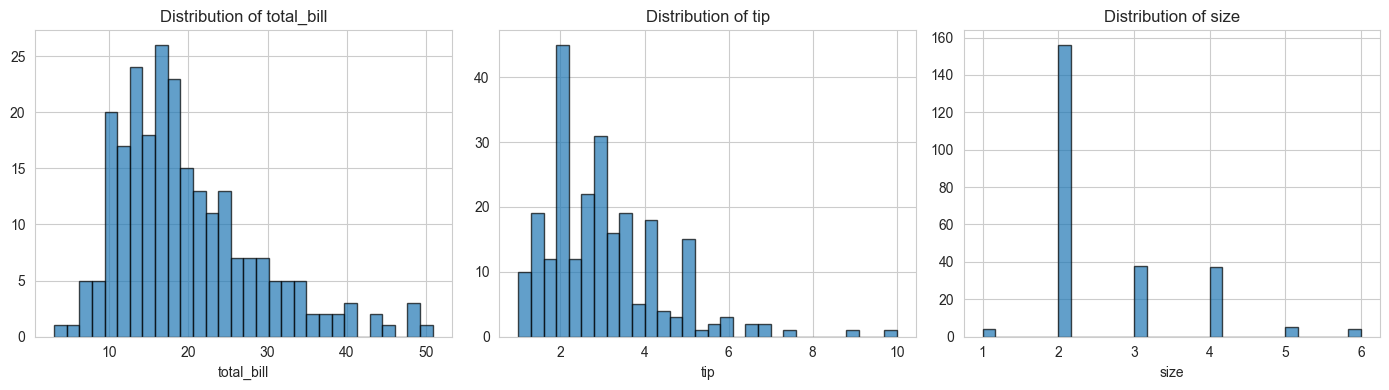

In [5]:
# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, col in zip(axes, numerical_cols):
    ax.hist(tips[col], bins=30, edgecolor='black', alpha=0.7)
    ax.set_xlabel(col)
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

---
## Feature Scaling

**Why scale features?**
1. **Faster convergence** in gradient descent
2. **Prevents large-value features from dominating**
3. **Avoids numerical issues** (overflow, NaN)

**Critical rule**: If you scale features during training, you must apply the same scaling during prediction!

### Technique 1: Min-Max Scaling

**Formula**: `x' = (x - x_min) / (x_max - x_min)`

**Result**: Values in [0, 1] range

**Works well when**: Data has known bounds and few extreme outliers

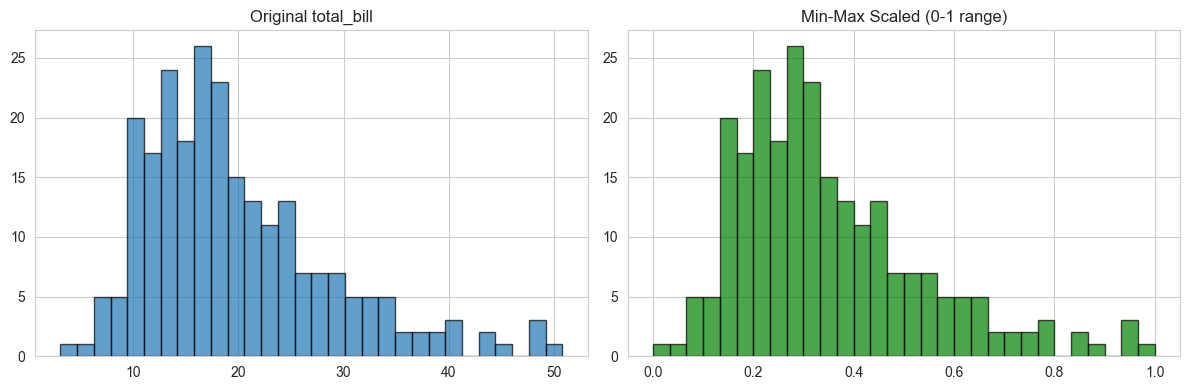

Original range: [3.07, 50.81]
Scaled range: [0.00, 1.00]


In [6]:
# Min-Max scaling example
original = tips['total_bill'].values
x_min, x_max = original.min(), original.max()
scaled = (original - x_min) / (x_max - x_min)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(original, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Original total_bill')
axes[1].hist(scaled, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Min-Max Scaled (0-1 range)')
plt.tight_layout()
plt.show()

print(f"Original range: [{x_min:.2f}, {x_max:.2f}]")
print(f"Scaled range: [{scaled.min():.2f}, {scaled.max():.2f}]")

### Technique 2: Z-Score Scaling (Standardization)

**Formula**: `x' = (x - mean) / std`

**Result**: Mean = 0, Standard deviation = 1

**Works well when**: You want to compare features on the same scale; required by some algorithms (e.g., SVM, PCA)

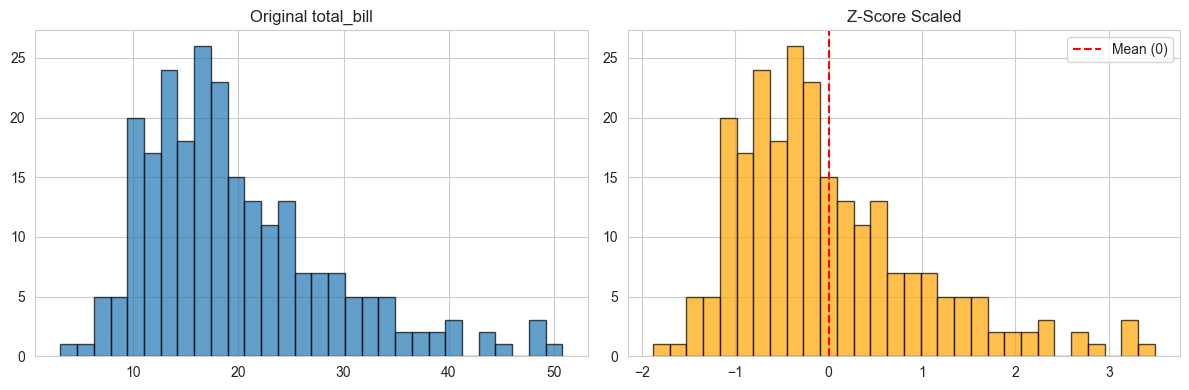

Z-scaled: mean=-0.0000, std=1.00


In [7]:
# Z-score scaling example
original = tips['total_bill'].values
mean, std = original.mean(), original.std()
z_scaled = (original - mean) / std

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(original, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Original total_bill')
axes[1].hist(z_scaled, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Z-Score Scaled')
axes[1].axvline(x=0, color='red', linestyle='--', label='Mean (0)')
axes[1].legend()
plt.tight_layout()
plt.show()

print(f"Z-scaled: mean={z_scaled.mean():.4f}, std={z_scaled.std():.2f}")

### Technique 3: Mean Normalization

**Formula**: `x' = (x - mean) / (x_max - x_min)`

**Result**: Values centered around 0, typically in [-0.5, 0.5] range

**Works well when**: You want centered data but with bounded range (combines aspects of Min-Max and Z-score)

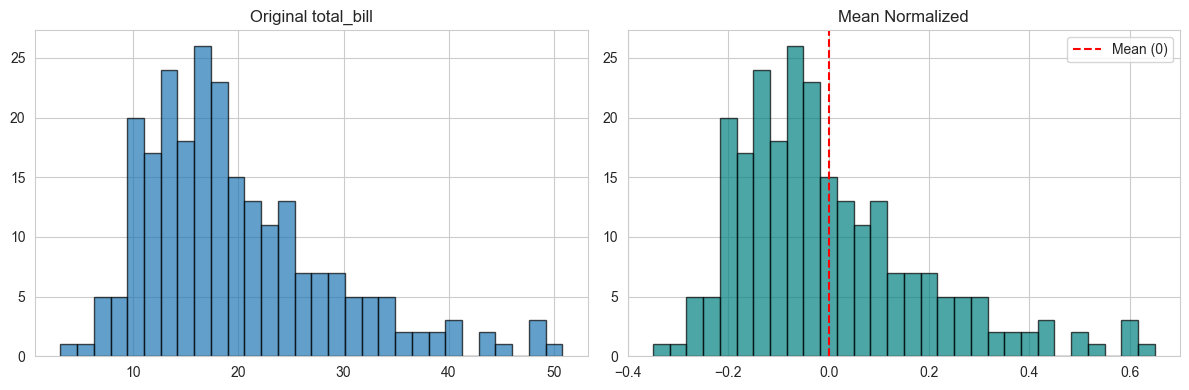

Mean normalized: range=[-0.35, 0.65], mean=-0.0000


In [8]:
# Mean normalization example
original = tips['total_bill'].values
mean = original.mean()
x_min, x_max = original.min(), original.max()
mean_normalized = (original - mean) / (x_max - x_min)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(original, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Original total_bill')
axes[1].hist(mean_normalized, bins=30, edgecolor='black', alpha=0.7, color='teal')
axes[1].set_title('Mean Normalized')
axes[1].axvline(x=0, color='red', linestyle='--', label='Mean (0)')
axes[1].legend()
plt.tight_layout()
plt.show()

print(f"Mean normalized: range=[{mean_normalized.min():.2f}, {mean_normalized.max():.2f}], mean={mean_normalized.mean():.4f}")

### Technique 4: Log Scaling

**Formula**: `x' = log(x + 1)` (called log1p)

**Why log?** The logarithm compresses large values while spreading out small values. This is perfect for right-skewed data where most values are small but a few are very large.

```
Original:   [1, 10, 100, 1000, 10000]
Log-scaled: [0.7, 2.4, 4.6, 6.9, 9.2]  ← range compressed from 10000 to ~9
```

**Why +1?** 
- `log(0)` is undefined (negative infinity)
- `log(1) = 0`, so adding 1 ensures zeros map to 0 instead of breaking
- This is why it's called `log1p` (log of 1 plus x) in NumPy

**Best for**: Right-skewed data (income, website visits, word frequencies)

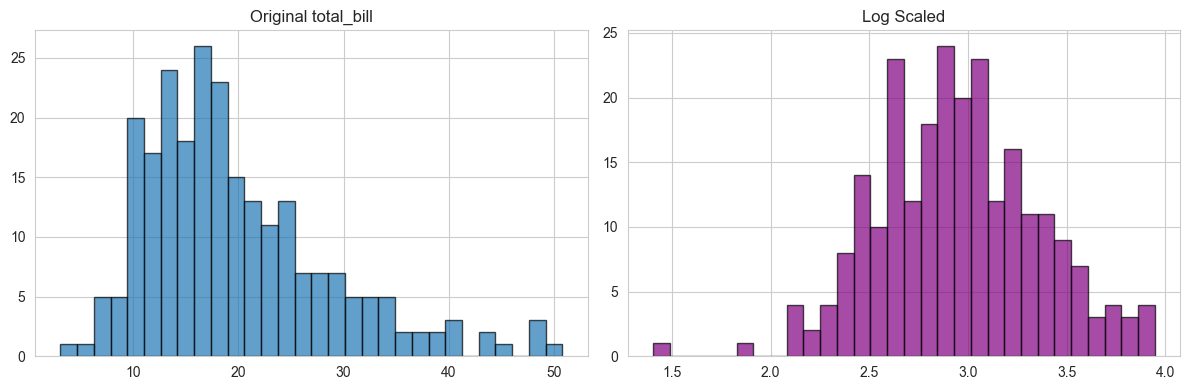

Original max: 50.81 -> Log scaled: 3.95


In [12]:
# Log scaling example
original = tips['total_bill'].values
log_scaled = np.log(original + 1)  # +1 to handle zeros
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(original, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Original total_bill')
axes[1].hist(log_scaled, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1].set_title('Log Scaled')
plt.tight_layout()
plt.show()

print(f"Original max: {original.max():.2f} -> Log scaled: {log_scaled.max():.2f}")

### Technique 5: Clipping

**Method**: Cap values at threshold(s)

**Best for**: Features with extreme outliers

**Caution**: Some outliers are meaningful — clip carefully!

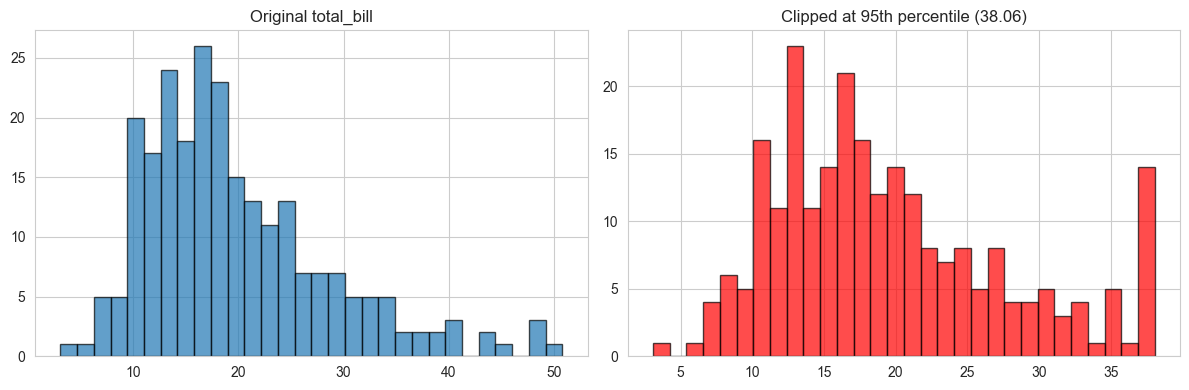

Values clipped: 13 (5.3%)


In [13]:
# Clipping example
original = tips['total_bill'].values
p95 = np.percentile(original, 95)
clipped = np.clip(original, a_min=None, a_max=p95)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(original, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Original total_bill')
axes[1].hist(clipped, bins=30, edgecolor='black', alpha=0.7, color='red')
axes[1].set_title(f'Clipped at 95th percentile ({p95:.2f})')
plt.tight_layout()
plt.show()

print(f"Values clipped: {np.sum(original > p95)} ({np.sum(original > p95)/len(original)*100:.1f}%)")

### Choosing the Right Technique

| Technique | When to Use |
|-----------|-------------|
| **Min-Max Scaling** | Known bounds, few outliers, need [0,1] range |
| **Z-Score (Standardization)** | Comparing features, algorithms that assume standardized input |
| **Mean Normalization** | Want centered data with bounded range |
| **Log Scaling** | Right-skewed data, values spanning orders of magnitude |
| **Clipping** | Extreme outliers that are likely noise |

**Note**: These can be combined! (e.g., clip outliers first, then standardize)

### Using sklearn Scalers

In practice, use sklearn's built-in scalers — they handle fitting and transforming consistently:

| sklearn Class | Technique |
|---------------|-----------|
| `MinMaxScaler` | Min-Max scaling to [0, 1] |
| `StandardScaler` | Z-score (mean=0, std=1) |
| `RobustScaler` | Uses median & IQR (robust to outliers) |
| `PowerTransformer` | Box-Cox or Yeo-Johnson (reduces skewness) |

**Important**: Always `fit()` on training data only, then `transform()` both train and val/test.

> *Note: here we use  train/test, not train/val/test, as it is sufficient for demonstrating feature scaling. But the key principle — fit on train only — applies regardless of how many splits you have.*

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Example: StandardScaler with proper train/test split
X = tips[['total_bill']].values
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

scaler = StandardScaler()

# Fit ONLY on training data (learns mean & std from train set)
scaler.fit(X_train)

# Transform both using the SAME parameters learned from training
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print(f"\nLearned from train - mean: {scaler.mean_[0]:.2f}, std: {scaler.scale_[0]:.2f}")
print(f"\nTrain scaled mean: {X_train_scaled.mean():.4f}")  # Exactly 0
print(f"Test scaled mean:  {X_test_scaled.mean():.4f}")    # Not 0 (uses train params)

Train size: 195, Test size: 49

Learned from train - mean: 20.22, std: 8.75

Train scaled mean: 0.0000
Test scaled mean:  -0.2458


---
## Binning (Bucketing)

**What is binning?**

Binning groups numerical values into discrete buckets, converting numerical to categorical data.

**When to use:**
- Non-linear relationship between feature and target
- Data is clustered rather than continuous
- Reduce impact of outliers

**Two strategies:**
1. **Equal-width**: Bins have equal size ranges
2. **Quantile**: Bins have equal sample counts

In [15]:
# Binning example
data = tips['total_bill'].values
n_bins = 4

# Equal-width bins
equal_edges = np.linspace(data.min(), data.max(), n_bins + 1)
print("Equal-width bin edges:", equal_edges.round(2))

# Quantile bins
quantile_edges = np.percentile(data, np.linspace(0, 100, n_bins + 1))
print("Quantile bin edges:", quantile_edges.round(2))

Equal-width bin edges: [ 3.07 15.   26.94 38.88 50.81]
Quantile bin edges: [ 3.07 13.35 17.8  24.13 50.81]


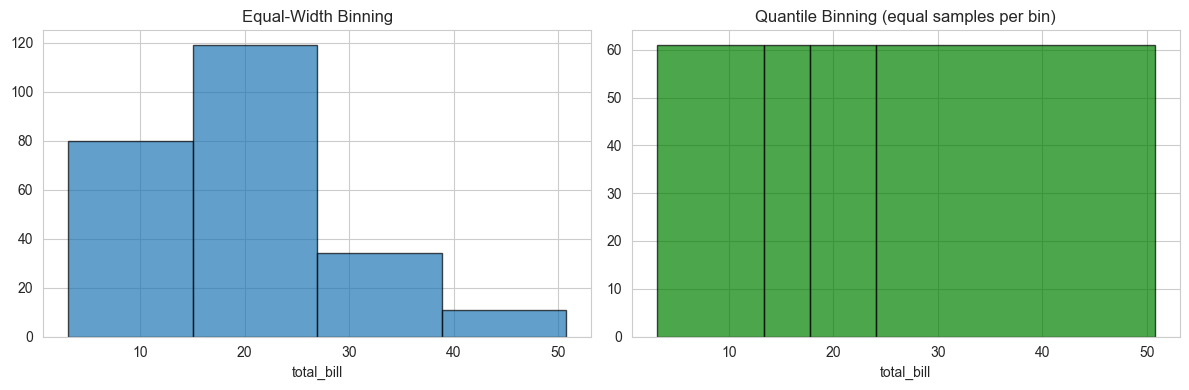

In [16]:
# Visualize binning
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(data, bins=equal_edges, edgecolor='black', alpha=0.7)
axes[0].set_title('Equal-Width Binning')
axes[0].set_xlabel('total_bill')

axes[1].hist(data, bins=quantile_edges, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Quantile Binning (equal samples per bin)')
axes[1].set_xlabel('total_bill')

plt.tight_layout()
plt.show()

### When Binning Helps: Non-Linear Relationships

Let's see how tip percentage varies across bill ranges:

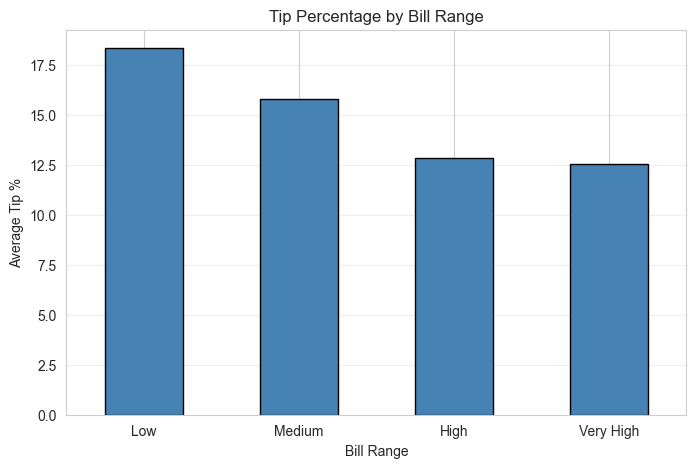

In [17]:
# Create bill bins and analyze tip percentage
tips['bill_bin'] = pd.cut(tips['total_bill'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])
tips['tip_pct'] = tips['tip'] / tips['total_bill'] * 100

# Mean tip percentage per bin
tip_by_bin = tips.groupby('bill_bin')['tip_pct'].mean()

plt.figure(figsize=(8, 5))
tip_by_bin.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Bill Range')
plt.ylabel('Average Tip %')
plt.title('Tip Percentage by Bill Range')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

# Clean up
tips.drop(['bill_bin', 'tip_pct'], axis=1, inplace=True)

---
## Polynomial Features

**What are polynomial features?**

Polynomial features create new features by raising existing ones to powers and/or combining them. This helps linear models capture non-linear relationships.

**Example**: From features `x₁, x₂`, create:
- Squared terms: `x₁², x₂²`
- Interaction term: `x₁ × x₂`

**When to use:**
- The relationship between feature and target is non-linear
- You want to capture interactions between features
- Using a linear model but need non-linear patterns

Let's first create them manually, then use sklearn:

In [18]:
# Manual approach: create polynomial features with pandas
tips_poly = tips[['total_bill', 'size']].copy()

# Add squared terms
tips_poly['total_bill^2'] = tips_poly['total_bill'] ** 2
tips_poly['size^2'] = tips_poly['size'] ** 2

# Add interaction term (feature1 × feature2)
tips_poly['total_bill*size'] = tips_poly['total_bill'] * tips_poly['size']

print("Manual polynomial features:")
tips_poly.head()

Manual polynomial features:


,total_bill,size,total_bill^2,size^2,total_bill*size
0,16.99,2,288.6601,4,33.98
1,10.34,3,106.9156,9,31.02
2,21.01,3,441.4201,9,63.03
3,23.68,2,560.7424,4,47.36
4,24.59,4,604.6681,16,98.36


In [19]:
# Using sklearn (same result, but handles any degree automatically)
from sklearn.preprocessing import PolynomialFeatures

X = tips[['total_bill', 'size']].values

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

print("sklearn PolynomialFeatures:")
print(f"Original shape: {X.shape} → Polynomial shape: {X_poly.shape}")
print(f"\nFeature names: {poly.get_feature_names_out()}")
print(f"\nFirst row comparison:")
print(f"  Manual:  {tips_poly.loc[0, ['total_bill', 'size', 'total_bill^2', 'total_bill*size', 'size^2']].values}")
print(f"  sklearn: {X_poly[0]}")

sklearn PolynomialFeatures:
Original shape: (244, 2) → Polynomial shape: (244, 5)

Feature names: ['x0' 'x1' 'x0^2' 'x0 x1' 'x1^2']

First row comparison:
  Manual:  [ 16.99     2.     288.6601  33.98     4.    ]
  sklearn: [ 16.99     2.     288.6601  33.98     4.    ]


---
## Data Cleaning (Scrubbing)

Real-world data is messy. Common problems:

1. **Missing values** — sensors fail, users skip fields
2. **Duplicate examples** — data uploaded twice
3. **Out-of-range values** — typos, sensor errors
4. **Inconsistent labels** — different annotators

**The fix**: Remove bad examples OR impute corrected values.

In [20]:
# Create messy data for demo
messy = tips[['total_bill', 'tip', 'size']].copy()

# Add problems
messy.loc[0, 'total_bill'] = np.nan  # Missing
messy.loc[5, 'tip'] = 500  # Outlier (typo)
messy = pd.concat([messy, messy.iloc[:3]])  # Duplicates

print("Messy data issues:")
print(f"  Missing values: {messy.isnull().sum().sum()}")
print(f"  Duplicates: {messy.duplicated().sum()}")
print(f"  Tip > 100: {(messy['tip'] > 100).sum()}")

Messy data issues:
  Missing values: 2
  Duplicates: 5
  Tip > 100: 1


In [21]:
# Clean the data
clean = messy.copy()

# 1. Remove duplicates
clean = clean.drop_duplicates()

# 2. Fix outliers (cap at reasonable value)
clean.loc[clean['tip'] > 100, 'tip'] = np.nan

# 3. Impute missing with median
for col in clean.columns:
    clean[col] = clean[col].fillna(clean[col].median())

print(f"Original data: {len(messy)} rows, {messy.isnull().sum().sum()} missing")
print(f"Clean data: {len(clean)} rows, {clean.isnull().sum().sum()} missing")

Original data: 247 rows, 2 missing
Clean data: 242 rows, 0 missing


### Imputation Strategies

| Strategy | When to Use |
|----------|-------------|
| **Mean** | Normal distribution, no outliers |
| **Median** | Skewed data, presence of outliers |
| **Mode** | Categorical features |
| **Drop rows** | Small fraction missing, large dataset |

---
## Before/After Comparison: Scaling Impact on Model Performance

Let's see how different scaling techniques affect model performance. We'll train a Linear Regression model to predict tips and compare:
1. **Baseline**: No scaling
2. **Min-Max Scaling**
3. **Z-Score (Standardization)**
4. **Polynomial Features**

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Prepare data
X = tips[['total_bill', 'size']].values
y = tips['tip'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}

# 1. Baseline (no scaling)
model = LinearRegression()
model.fit(X_train, y_train)
results['Baseline'] = mean_absolute_error(y_test, model.predict(X_test))

# 2. Min-Max Scaling
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)
model.fit(X_train_mm, y_train)
results['Min-Max'] = mean_absolute_error(y_test, model.predict(X_test_mm))

# 3. Z-Score (Standardization)
scaler_z = StandardScaler()
X_train_z = scaler_z.fit_transform(X_train)
X_test_z = scaler_z.transform(X_test)
model.fit(X_train_z, y_train)
results['Z-Score'] = mean_absolute_error(y_test, model.predict(X_test_z))

# 4. Polynomial Features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model.fit(X_train_poly, y_train)
results['Polynomial (d=2)'] = mean_absolute_error(y_test, model.predict(X_test_poly))

print("Model Performance (MAE - lower is better):\n")
for name, mae in results.items():
    print(f"  {name:18s}: ${mae:.3f}")

Model Performance (MAE - lower is better):

  Baseline          : $0.664
  Min-Max           : $0.664
  Z-Score           : $0.664
  Polynomial (d=2)  : $0.713


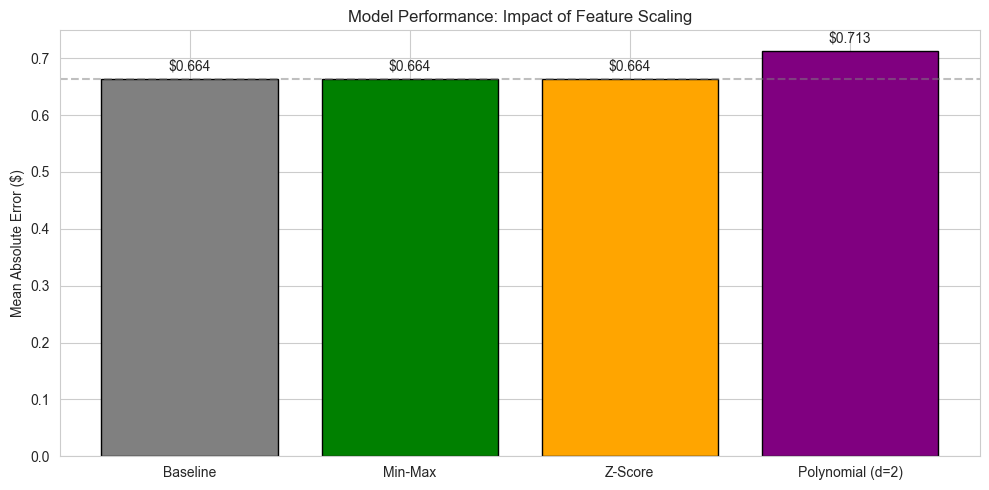

In [23]:
# Visualize results
plt.figure(figsize=(10, 5))
colors = ['gray', 'green', 'orange', 'purple']
bars = plt.bar(results.keys(), results.values(), color=colors, edgecolor='black')
plt.ylabel('Mean Absolute Error ($)')
plt.title('Model Performance: Impact of Feature Scaling')
plt.axhline(y=results['Baseline'], color='gray', linestyle='--', alpha=0.5, label='Baseline')

# Add value labels
for bar, mae in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'${mae:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Observations**:
- For Linear Regression, Min-Max and Z-Score scaling produce **identical MAE** — the model adjusts weights accordingly
- **Polynomial features didn't help here** — the relationship is already fairly linear, and adding polynomial terms can sometimes hurt performance (overfitting risk)
- **Scaling matters more** for gradient descent-based training, regularized models (Ridge, Lasso), and distance-based models (KNN, SVM)

> **Takeaway**: While crafting complex features sometimes helps a lot, more complex features aren't always better. Always evaluate on val/test data!

---
## Exercises

### Exercise 1: Choose the Right Scaling Technique

Which technique would you use for:
1. User age (18-80, roughly uniform)
2. Website visit counts (power-law distribution)
3. Test scores (0-100, roughly normal)
4. Salary data with billionaire outliers

In [ ]:
# TODO: Write your answers as comments
# 1. User age: Min-Max scaling
# 2. Website visits: Log scaling
# 3. Test scores: z-score or Min-max
# 4. Salary with billionaires: clipping to remove extreme outliers then z-score

<details>
<summary><b>Click for Solution</b></summary>

1. **User age**: Min-Max scaling — bounded range [18, 80]
2. **Website visits**: Log scaling — right-skewed, spans orders of magnitude
3. **Test scores**: Z-score or Min-Max — both work; Min-Max if you want [0,1]
4. **Salary with billionaires**: Clip first (remove extreme outliers), then Z-score

</details>

### Exercise 2: Implement Scaling Functions

Implement Min-Max scaling and Z-score standardization from scratch:

In [25]:
# TODO: Implement these functions

def min_max_scale(x):

    """Scale x to [0, 1] range."""
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def standardize(x):
    """Standardize x to mean=0, std=1."""
    return (x - np.mean(x)) / np.std(x)

# Test your functions
test_data = np.array([10, 20, 30, 40, 50])
print(min_max_scale(test_data))  # Should be [0, 0.25, 0.5, 0.75, 1.0]
print(standardize(test_data))    # Mean should be ~0

[0.   0.25 0.5  0.75 1.  ]
[-1.41421356 -0.70710678  0.          0.70710678  1.41421356]


<details>
<summary><b>Click for Solution</b></summary>

```python
def min_max_scale(x):
    x_min, x_max = np.min(x), np.max(x)
    return (x - x_min) / (x_max - x_min)

def standardize(x):
    return (x - np.mean(x)) / np.std(x)
```

</details>

---
## Key Takeaways

1. **Feature vectors** are numerical arrays that models train on

2. **Feature scaling** transforms values to similar ranges:
   - **Min-Max**: Maps to [0, 1] — use for bounded data
   - **Z-Score (Standardization)**: Centers at 0 with std=1 — use for comparing features
   - **Mean Normalization**: Centers at 0 with bounded range
   - **Log**: Compresses right-skewed data
   - **Clipping**: Handles extreme outliers before other transforms

3. **Polynomial features** help linear models capture non-linear relationships

4. **Binning** converts numerical to categorical — useful for non-linear relationships

5. **Data cleaning** fixes missing values, duplicates, and outliers

6. **Critical rule**: Apply the same transformations during training AND prediction